### Importing Necessary Libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

### Dataset Construction
* Generated 100 points between -10 to 10
* Defined $\frac{\sin x}{x}$ function with guassian noise
* Plotted it for visualization

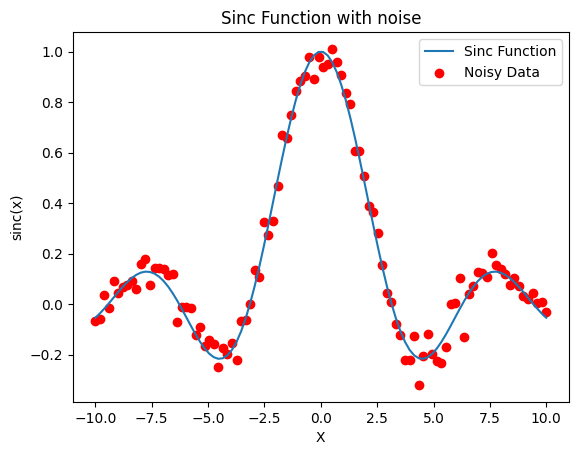

In [37]:
torch.random.manual_seed(864)
x = torch.linspace(-10,10, 100)
sinc = torch.where(x == 0, torch.tensor(1.0), torch.sin(x)/x)
noisy_sinc = sinc + 0.05*torch.randn(x.size())
plt.figure()
plt.plot(x.numpy(), sinc.numpy(),label = 'Sinc Function')
plt.scatter(x.numpy(), noisy_sinc.numpy(), color='red', label = 'Noisy Data')
plt.title('Sinc Function with noise')
plt.xlabel('X')
plt.ylabel('sinc(x)')
plt.legend()
plt.show()

### Defining MLP model:
* Defined MLP model with subclass ```nn.Module```.
* This MLP has 1 Input Layer, 2 Hidden Layer and 1 Output Layer(all of them fully connected).
* ```forward``` Takes input $x$ and does forward pass through MLP.



---

### Hyperparameters:
* ```batch_size``` = 32
* ```lr```(learning rate) = 0.1
* ```max_epochs``` = 100

---
I am using "mean squared loss" as loss function, "Stochastic Gradient Descent" as optimizer.

In [38]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden1_dim, hidden2_dim, output_dim):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden1_dim)
    self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
    self.fc3 = nn.Linear(hidden2_dim, output_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

batch_size = 64
lr = 0.1
max_epochs = 100

loss_function = nn.MSELoss()
model = MLP(1, 64, 64, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Preparing Data to Load into MLP:
* Converted input and output as tensor
* ```loader``` divides the data into nice batch.

In [39]:
x_tensor = torch.tensor(x, dtype = torch.float32).unsqueeze(1)
y_tensor = torch.tensor(noisy_sinc, dtype = torch.float32).unsqueeze(1)
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

<ipython-input-39-5a0be158ac0d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype = torch.float32).unsqueeze(1)
<ipython-input-39-5a0be158ac0d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(noisy_sinc, dtype = torch.float32).unsqueeze(1)


### Training:
* Collecting training loss over epochs in ```training_loss```.
* Predicting using ```model(x_batch)```.
* Calculating loss.
* ```optimizer.zero_grad()``` resets the gradients.
* ```loss.backward()``` does backpropagating.
* ```optimizer.step()``` updates the weights.
* Prints loss every 10th epoch.

In [40]:
training_loss = []

for epoch in range(max_epochs):
  epoch_loss = 0.0
  for x_batch, y_batch in loader:
    #print(x_batch.shape)
    y_pred = model(x_batch)
    loss = loss_function(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  training_loss.append(epoch_loss/len(loader))
  if(epoch % 10 == 0):
    print(f"Epoch {epoch}, Loss: {epoch_loss/len(loader)}")

Epoch 0, Loss: 34.097049564123154
Epoch 10, Loss: 0.07104242406785488
Epoch 20, Loss: 0.017884152941405773
Epoch 30, Loss: 0.01266039302572608
Epoch 40, Loss: 0.009286877699196339
Epoch 50, Loss: 0.00935681164264679
Epoch 60, Loss: 0.007978799287229776
Epoch 70, Loss: 0.008029436692595482
Epoch 80, Loss: 0.007538086036220193
Epoch 90, Loss: 0.007049058331176639


### Plotting Training loss vs Epochs

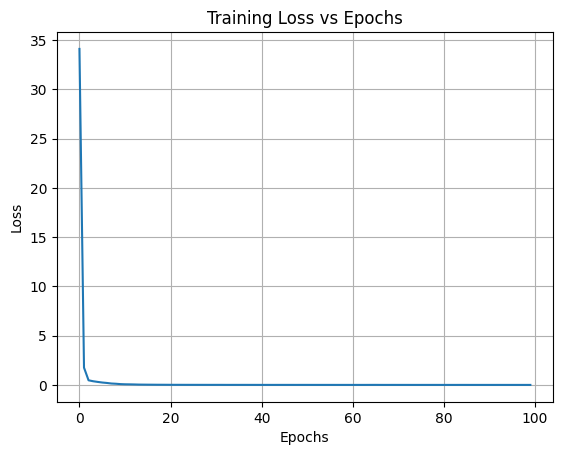

In [41]:
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.show()

### Visualizing Decision Boundary:
* Creating meshgrid using ```np.linspace``` and ```np.meshgrid```.
* Setting model into evaluate mode.
* Calculating prediction using model at each point in grid.
* Plotting both prediction and actual function to see visualize the result.

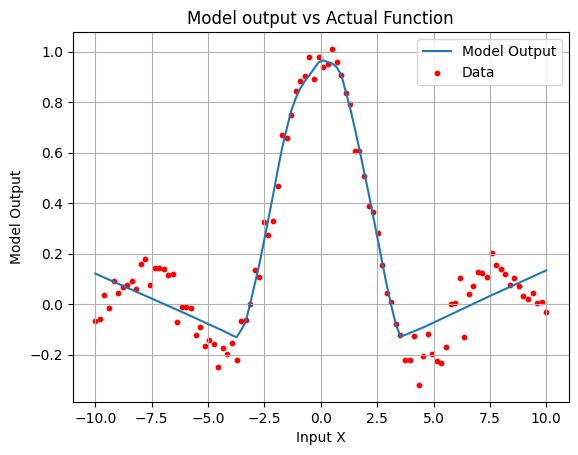

In [42]:
x_value = np.linspace(-10,10, 100)
xx, yy = np.meshgrid(x_value, [0])

grid = torch.tensor(xx.flatten(), dtype = torch.float32).unsqueeze(1)
x_test = torch.tensor(xx, dtype = torch.float32).unsqueeze(1)

model.eval()
with torch.no_grad():
    y_preds = model(grid)

preds_reshaped = y_preds.view(xx.shape)


plt.plot(x_value, preds_reshaped[0].numpy(), label='Model Output')
plt.scatter(x.numpy(), noisy_sinc.numpy(), color='red', s=10, label='Data')
plt.xlabel("Input X")
plt.ylabel("Model Output")
plt.title("Model output vs Actual Function")
plt.grid(True)
plt.legend()
plt.show()

### 3. Introduction to CNN with PyTorch

### Importing the data from kaggle

In [43]:
import kagglehub

path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rockpaperscissors


### Importing necessary libraries

In [44]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision

### Using cuda for faster training if available

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Custom PyTorch Dataset class:

1. ```__init__```
  * ```root_dir``` : root directory of the dataset
  * ```transform```: transform given for processing.
  * ```classes```: Name of the classes image belongs to.
  * ```image_paths ```: Path of each image in the dataset
  * ```labels ``` : Will contain the corresponding label for each image.(0 - Rock, 1- Paper, 2- Scissors)

  Then we loop through the class and store the location of class directory(rock, paper, scissors) in ```cls_dir```. Similarly looping through each ```cls_dir``` we store path of each image in ```img_path``` and append that to the array ```img_paths``` and the respective label in the array ```labels```

2. ```___len___```: Returns the number of images in the dataset.

3. ```__getitem___```: Takes the index to return the image and its corresponding label.

In [46]:
class RockPaperScissorsDataset(Dataset):
  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform
    self.classes = ['rock', 'paper', 'scissors']
    self.image_paths = []
    self.labels = []

    for i, cls in enumerate(self.classes):
      cls_dir = os.path.join(root_dir, cls)
      for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        self.image_paths.append(img_path)
        self.labels.append(i)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image,label

* Resizes images into $128 \times 128$ pixels because model expects fix size input.
* Converts image into Tensor.
* Normalize channel wise (R,G,B)

In [64]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

* ```dataset_path``` is path for the image.
* ```dataset``` process the data using class ```RockPaperScissorsDataset```.
* We split the data into 80-20 for training and testing.
* ```train_loader```, ```test_loader``` converts it into nice batches for training.

In [65]:
dataset_path = path
dataset = RockPaperScissorsDataset(dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 1750
Test samples: 438


### Visualizing some images:

1. Function ```imshow```:
  * Unnormalizing the image.
  * convering image to into numpy array.
  * showing this image using ```plt.imshow```

2. ```iter(dataloader)``` creates an iterator over the dataloader.
3. ```next(dataloader)``` returns the next batch.
4. Then display the first 8 images in a grid.


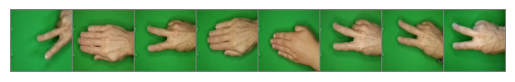

Labels: ['scissors', 'paper', 'scissors', 'paper', 'paper', 'scissors', 'scissors', 'scissors']


In [66]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', [dataset.classes[i] for i in labels[:8]])

### Simple CNN:
* This just takes the image and applies convolution once with given input, output channel, kernel, stride and padding.


In [75]:
class simpleCNN(nn.Module):
  def __init__(self, in_channels = 3, out_channels=3, kernel_size =3, stride = 1, padding=1):
    super(simpleCNN, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

  def forward(self, x):
    print(f"Input Shape: {x.shape}")
    x = self.conv(x)
    print(f"shape after convolution {x.shape}")
    return (x)

### Visualizing one sample image:
* ```input_tensor``` is tensor of the input image.
* We defined kernel for blurring the image.
* We stack the 3 RGB kernel to get final input kernel.
* ```apply_kernel``` takes kernel and input_tensor
  1. Set model.
  2. Applying kernel(Each for R, G, B to produce color image).
  3. predictiing output and returning

* Applying ```apply_kernel``` for blur, sharpen and edge detection.

### Expected Dimension of Output:
* Input: $[1,3,128,128]$
* We applied conv layer with ```in_channel = 3``` and ```out_channel = 3```.
* So output should be $[1,3,128,128]$.(if I had done ```out_channel = 1 ```it should be $[1,1,128,128]$)

In [85]:
img_path = f"{dataset_path}/paper/04l5I8TqdzF9WDMJ.png"
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

blur_kernel_r = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=torch.float32)
blur_kernel_g = torch.tensor([[1/9]*3]*3, dtype=torch.float32)
blur_kernel_b = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32)
blur_kernel = torch.stack([blur_kernel_r, blur_kernel_g, blur_kernel_b]).unsqueeze(1)
def apply_kernel(kernel, input_tensor):
  #custom_kernel = torch.stack([blur_kernel_r, blur_kernel_g, blur_kernel_b]).unsqueeze(1)
  model = simpleCNN(in_channels=3, out_channels=3)
  model.conv.weight.data = kernel
  model.conv.bias.data.zero_()
  model.conv.groups = 3
  with torch.no_grad():
    output = model(input_tensor)
  return output

blur_output = apply_kernel(blur_kernel, input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
shape after convolution torch.Size([1, 3, 128, 128])


### Plotting Images:
1. ```imshow```:
  * ```image = tensor.squeeze().detach().cpu().numpy()```:
    * .squeeze: removes dimension of size 1.
    * .detach: prevents PyTorch from doing backprop.
    * .cpu: moving tensor to CPU as matplotlib doesnt work with GPU
2. Plotting image

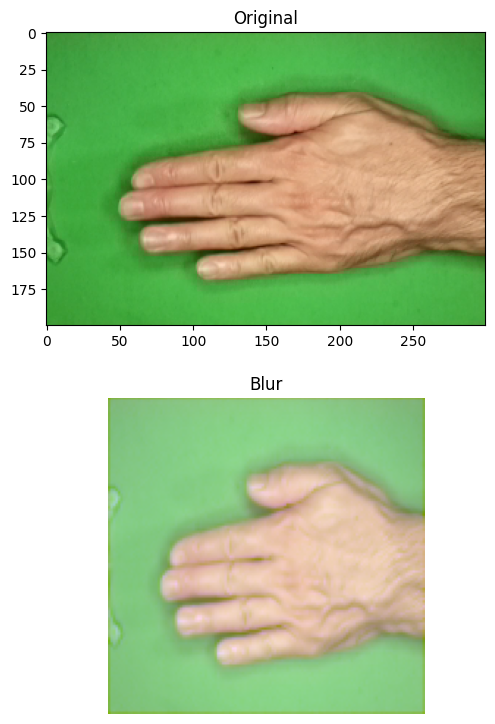

In [86]:
def imshow(tensor, title):
    image = tensor.squeeze().permute(1,2,0).detach().cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min() + 1e-5)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(5, 15))
plt.subplot(4, 1, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(4, 1, 2)
imshow(blur_output, "Blur")
plt.tight_layout()
plt.show()

### CNN with Pooling(conv + pooling):
1. Its just like ```simpleCNN``` but with added pooling
2. Method ```forward```: Applies convolution and Pooling and prints the shape

In [53]:
class CNN_with_pooling(nn.Module):
  def __init__(self):
    super(CNN_with_pooling, self).__init__()

    self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride =2)

  def forward(self, x):
    print(f"Input shape: {x.shape}")
    x = self.conv(x)
    print(f"After conv: {x.shape}")
    x = self.pool(x)
    print(f"After pool: {x.shape}")

    return x

### Understanding Output:
* Input Shape: $[1,3,128,128]$
* Our nn.Conv2d has ```in_channel =3``` and ```out_channel = 16``` so it should give output as $[1,16,128,128]$
* Our MaxPool2d has ```kernel_size = 2```, ```stride= 2```, so it will decrease height and width by factor of $2$.
* So final Output = $[1,16,64,64]$

### Visualizing Feature Maps:
* We see 16 feature maps, each one corresponding to an output channel from conv layer.
* These feature maps show what kind of patterns or textures each filter is detecting.


Input shape: torch.Size([1, 3, 128, 128])
After conv: torch.Size([1, 16, 128, 128])
After pool: torch.Size([1, 16, 64, 64])


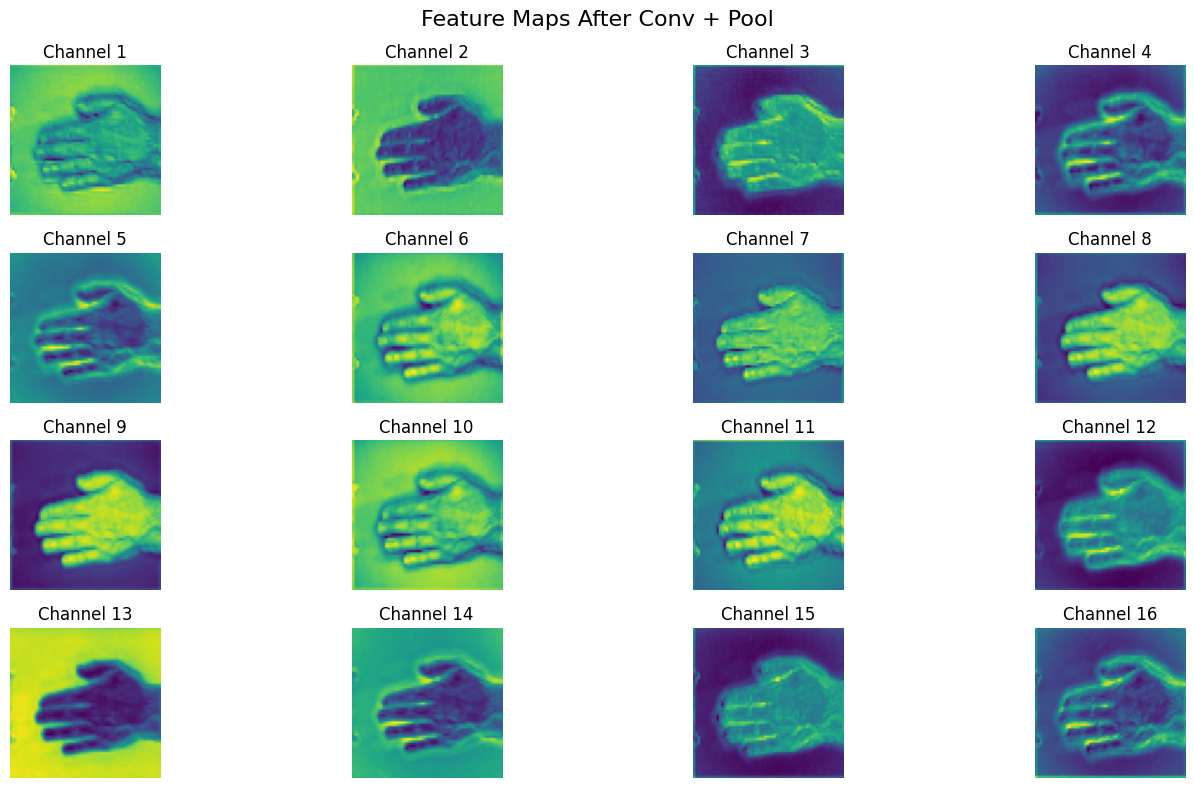

Input shape: torch.Size([1, 3, 128, 128])
After conv: torch.Size([1, 16, 128, 128])
After pool: torch.Size([1, 16, 64, 64])


In [87]:
model = CNN_with_pooling()
with torch.no_grad():
    feature_maps = model(input_tensor)  # Shape: [1, 16, H, W]

# Visualize each feature map
feature_maps = feature_maps.squeeze(0)  # Shape: [16, H, W]

plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feature_maps[i].cpu().numpy(), cmap='viridis')
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.suptitle("Feature Maps After Conv + Pool", fontsize=16)
plt.tight_layout()
plt.show()
input = torch.randn(1, 3, 128, 128)
output = model(input)

### CNN_with_GAP (conv + pool + gap):
1. What does GAP do?:
  * Calculates average output of each feature map.
2. Understanding output dimension:
  * As GAP does the average output it should change dimension from $[1,16,64,64]$ to $[1,16,1,1]$

In [55]:
class CNN_with_GAP(nn.Module):
  def __init__(self):
    super(CNN_with_GAP, self).__init__()

    self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.gap = nn.AdaptiveAvgPool2d((1,1))

  def forward(self, x):
    print(f"Input shape: {x.shape}")
    x = self.conv(x)
    print(f"After conv: {x.shape}")
    x = self.pool(x)
    print(f"After pool: {x.shape}")
    x = self.gap(x)
    print(f"After GAP: {x.shape}")

    return x

model = CNN_with_GAP()
input = torch.randn(1, 3, 128, 128)
output = model(input)

Input shape: torch.Size([1, 3, 128, 128])
After conv: torch.Size([1, 16, 128, 128])
After pool: torch.Size([1, 16, 64, 64])
After GAP: torch.Size([1, 16, 1, 1])


### Final CNN [ (conv + relu + pool)$\times$ 3 + gap + 2 Fully connected Layer ]

* ```param``` = 1 will print the shape of the output matrix.

In [96]:
class CNN(nn.Module):
  def __init__ (self, param = 0):
    super(CNN, self).__init__()
    self.param = param

    #3 convolution layer following up :)

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.gap = nn.AdaptiveAvgPool2d((1,1))

    self.fc1 = nn.Linear(128,64)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64,3)

  def forward(self,x):
    if(self.param == 1):
      print(f"Input shape: {x.shape}")
    x = self.conv1(x)
    if(self.param == 1):
      print(f"After conv1: {x.shape}")
    x = self.relu1(x)
    #print(f"After relu1: {x.shape}")
    x = self.pool1(x)
    if(self.param == 1):
      print(f"After pool1: {x.shape}")
    x = self.conv2(x)
    if(self.param == 1):
      print(f"After conv2: {x.shape}")
    x = self.relu2(x)
    #print(f"After relu2: {x.shape}")
    x = self.pool2(x)
    if(self.param == 1):
      print(f"After pool2: {x.shape}")
    x = self.conv3(x)
    if(self.param == 1):
      print(f"After conv3: {x.shape}")
    x = self.relu3(x)
    #print(f"After relu3: {x.shape}")
    x = self.pool3(x)
    if(self.param == 1):
      print(f"After pool3: {x.shape}")
    x = self.gap(x)
    if(self.param == 1):
      print(f"After GAP: {x.shape}")
    x = x.view(x.size(0), -1)
    if(self.param == 1):
      print(f"After flatten: {x.shape}")

    x = self.fc1(x)
    if(self.param == 1):
      print(f"After hidden layer: {x.shape}")
    x = self.relu(x)
    #print(f"After relu: {x.shape}")
    x = self.fc2(x)
    if(self.param == 1):
      print(f"After output layer: {x.shape}")

    return x

### Output Dimensions for Complete CNN Model

In [97]:
model = CNN(param =1)
input = torch.randn(1, 3, 128, 128)
output = model(input)

Input shape: torch.Size([1, 3, 128, 128])
After conv1: torch.Size([1, 32, 128, 128])
After pool1: torch.Size([1, 32, 64, 64])
After conv2: torch.Size([1, 64, 64, 64])
After pool2: torch.Size([1, 64, 32, 32])
After conv3: torch.Size([1, 128, 32, 32])
After pool3: torch.Size([1, 128, 16, 16])
After GAP: torch.Size([1, 128, 1, 1])
After flatten: torch.Size([1, 128])
After hidden layer: torch.Size([1, 64])
After output layer: torch.Size([1, 3])


### Training CNN Model:
* Takes argument ```model```, ```train_dataset```, ```test_dataset```, ```epochs```, ```lr```, ```batch_size```.
* Converts dataset into nice batches using ```DataLoader```.
* We use CrossEntropyLoss as our loss function.
* We use SGD as optimizer with momentum and weight decay(penalizes large weights)
* In each epoch we transfer images and label to GPU.
* Then we train it using standard process(clear gradient -> prediction -> calculate loss -> update weights)
* Then we calculate ```train_accuracy``` and append it into array ```train_acc```.
* Then we do the same for Evaluation process but without updating the gradients.

In [98]:
def train_cnn(model, train_dataset, test_dataset, epochs, lr, batch_size):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

  train_acc = []
  test_acc = []

  for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()

      output = model(images)
      loss = loss_function(output, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_acc.append(100 * correct / total)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_acc.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

  return train_acc, test_acc

### Function to plot train and test accuracy:

In [99]:
def plotting_accuracy(train_acc, test_acc):
  plt.plot(train_acc, label='Train Accuracy')
  plt.plot(test_acc, label='Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

### Best Result I got after playing with hyperparameter for dozen of times :)

* ```in_channels``` and ```out_channels```: (3,32) -> (32,64) -> (64,128) -> (128,64) in fc1 -> (64,3) in fc2
* ```lr``` = $0.01$
* ```epochs``` = $30$
* ```batch_sizes``` = $32$

Epoch [1/30] - Train Acc: 34.00%, Test Acc: 36.99%
Epoch [2/30] - Train Acc: 35.43%, Test Acc: 32.65%
Epoch [3/30] - Train Acc: 34.57%, Test Acc: 34.02%
Epoch [4/30] - Train Acc: 34.40%, Test Acc: 37.44%
Epoch [5/30] - Train Acc: 38.17%, Test Acc: 44.29%
Epoch [6/30] - Train Acc: 37.66%, Test Acc: 39.27%
Epoch [7/30] - Train Acc: 36.69%, Test Acc: 49.32%
Epoch [8/30] - Train Acc: 42.46%, Test Acc: 57.53%
Epoch [9/30] - Train Acc: 50.74%, Test Acc: 60.96%
Epoch [10/30] - Train Acc: 52.86%, Test Acc: 59.59%
Epoch [11/30] - Train Acc: 59.31%, Test Acc: 62.56%
Epoch [12/30] - Train Acc: 55.60%, Test Acc: 70.78%
Epoch [13/30] - Train Acc: 64.57%, Test Acc: 70.55%
Epoch [14/30] - Train Acc: 62.74%, Test Acc: 76.48%
Epoch [15/30] - Train Acc: 67.09%, Test Acc: 70.78%
Epoch [16/30] - Train Acc: 67.66%, Test Acc: 59.13%
Epoch [17/30] - Train Acc: 69.31%, Test Acc: 81.96%
Epoch [18/30] - Train Acc: 81.20%, Test Acc: 90.64%
Epoch [19/30] - Train Acc: 83.03%, Test Acc: 89.95%
Epoch [20/30] - Train

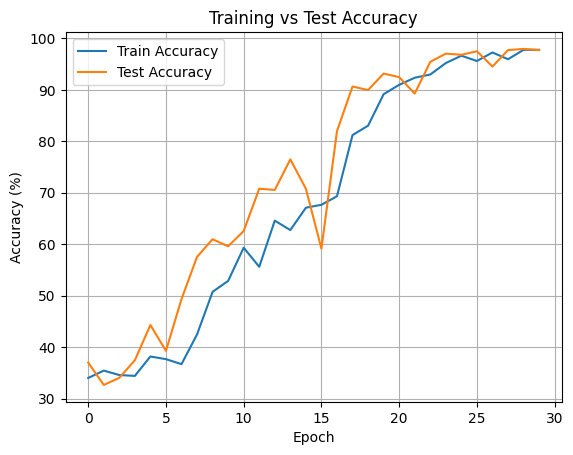

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(param = 0).to(device)

train_acc, test_acc = train_cnn(model, train_dataset, test_dataset, 30, 0.01, 32)
plotting_accuracy(train_acc, test_acc)